# 3가지 모델 비교 실험

relevance, ensemble, mutiagent RAG 3가지 모델에 대해서 결과를 출력하고 Gound Truth를 가지고 평가진행.


In [1]:
import os
import argparse
from pprint import pprint
from dotenv import load_dotenv
from langchain_teddynote import logging

from crew import Crew
from graph_relevancerag import RelevanceRAG
from graph_ensemblerag import EnsembleRAG
from graph_multiagentrag import MultiAgentRAG

from utils import *

# .env 파일 로드
load_dotenv(dotenv_path=".env")

# API 키 가져오기
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

# LangSmith 추적 기능을 활성화합니다. (선택적)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

# 프로젝트 이름을 입력합니다.
logging.langsmith("RAG 0204-Evaluation")

LangSmith 추적을 시작합니다.
[프로젝트명]
RAG 0204-Evaluation


## eval

In [2]:
def get_rag_instance(
    rag_method, 
    file_folder, 
    file_number, 
    # db_folder,
    chunk_size, 
    chunk_overlap,
    search_k,
    system_prompt, 
    model_name, 
    save_graph_png
):
    """
    RAG 클래스를 동적으로 받아서 인스턴스를 생성하는 함수
    
    Params:
        rag_method: RAG 방법 ("relevance-rag", "ensemble-rag", "multiagent-rag")
        file_folder: 논문 파일이 위치한 폴더 경로
        file_number: 처리할 논문 번호
        system_prompt: system prompt
        model_name: LLM 모델 명 ("gpt-4o", "gpt-4o-mini")
        save_graph_png: graph 저장 결정
        
    Return:
        생성된 RAG 모델 인스턴스
    """
    
    # RAG 모델 인스턴스 생성
    if rag_method == "relevance-rag":
        return RelevanceRAG(file_folder, file_number, chunk_size, chunk_overlap, search_k, system_prompt, model_name, save_graph_png)
        
    elif rag_method == "ensemble-rag":
        return EnsembleRAG(file_folder, file_number, chunk_size, chunk_overlap, search_k, system_prompt, model_name, save_graph_png)
        
    elif rag_method == "multiagent-rag":
        return MultiAgentRAG(file_folder, file_number, chunk_size, chunk_overlap, search_k, system_prompt, model_name, save_graph_png)


def main(
        config_folder:str="./config",
        data_folder:str="./data",
        file_num_list:list=[11],
        rag_method:str="multiagent-rag", 
        chunk_size:int=1000, 
        chunk_overlap:int=100, 
        search_k:int=10,    
        model_name:str="gpt-4o",
        save_graph_png:bool = False



):    
    category_names = ["CAM (Cathode Active Material)", "Electrode (half-cell)", "Morphological Properties", "Cathode Performance"]

    
    
    
    file_folder = f"{data_folder}/input_data"
    
    
    eval_df = pd.DataFrame(columns = ["paper_number","category_name","type", "result"])
    sample_name_searcher_question = """Use all of the NCM cathode sample names (e.g., 'NCM-622', 'pristine NCM', 'M-NCM') provided in the electrochemical performance section. You just output sample names. Do Not output like '- NCM622' , just output 'NCM622."""
    ## 각 논문에 대해 반복
    for file_number in file_num_list:
        print(f"#####    {file_number}번째 논문    #####")
        print(f"##       rag method     : {rag_method}")
        category_df = pd.DataFrame(columns = ["paper_number","category_name","type", "result"])
        ## Sample Name Searcher
        crew = Crew(
            file_folder=f"{data_folder}/input_data/", 
            file_number=file_number, 
            rag_method="crew-rag", 
            chunk_size=chunk_size, 
            chunk_overlap=chunk_overlap, 
            search_k=search_k, 
            model_name=model_name   
        )
        sample_name_searcher_chain = crew.sample_name_searcher()
        sample_names = sample_name_searcher_chain.invoke(sample_name_searcher_question)
        print(f"##       Sample Names    : {sample_names}")
        
        for category_number in range(1,5):
            print(f"##          Category Name   : {category_names[category_number-1]}")
            category_names = ["CAM (Cathode Active Material)", "Electrode (half-cell)", "Morphological Properties", "Cathode Performance"]
            

            ## config 파일과 system_prompt 와 invoke_input 불러오기
            system_prompt = load_system_prompt(config_folder=config_folder, category_number=category_number, rag_method=rag_method)
            invoke_input = load_invoke_input(config_folder=config_folder, category_number=category_number, rag_method=rag_method, sample_names=sample_names)
    
            ## graph 호출
            voltai_graph = get_rag_instance(
                rag_method=rag_method, 
                file_folder=f"{data_folder}/input_data/", 
                file_number=file_number, 
                chunk_size=chunk_size, 
                chunk_overlap=chunk_overlap, 
                search_k=search_k, 
                system_prompt=system_prompt,
                model_name=model_name, 
                save_graph_png=save_graph_png,
            ).graph
            
            ## 질문이 딕셔너리 형태일 경우와 아닌 경우를 처리
            if isinstance(invoke_input, dict):
                result = voltai_graph.invoke(**invoke_input)
            else:
                result = voltai_graph.invoke(*invoke_input)
            
            x = "000000"+f"{file_number}"
            x = x[-3:]
            file_name = f"paper_{x}"
            print(file_name)
            # JSON 파일 경로
            file_path = f"./data/ground_truth/{file_name}_gt.json"

            # JSON 파일 읽기
            with open(file_path, "r", encoding="utf-8") as file:
                gt = json.load(file)
            
            
            ## RAG method에 따른 결과 확인
            if result.get("answer"):
                temp_answer = result["answer"][0][category_names[category_number-1]]
            elif result.get("discussion"):
                print(result["discussion"])
                temp_answer = result["discussion"][0][category_names[category_number-1]]
            elif result.get("messages"):
                temp_answer = result["messages"][-1][category_names[category_number-1]]

            ## 결과 저장
            category_df.loc[category_number-1, "paper_number"] = file_number
            category_df.loc[category_number-1, "type"] = rag_method
            category_df.loc[category_number-1, "category_number"] = category_number
            category_df.loc[category_number-1, "category_name"] = category_names[category_number-1]
            category_df.loc[category_number-1, "result"] = [temp_answer] 
            category_df.loc[category_number-1, "ground_truth"] = [gt[category_names[category_number-1]]]

        
            print(f"##          Print {file_number} Result:")
            print("------------------------------------------------------------------")
            pprint(temp_answer, sort_dicts=False)        
        
            pprint(category_df.head())
        eval_df = pd.concat([eval_df, category_df])    

    return eval_df

In [3]:
file_ = [11,16,22,35,39,40,41,42,44,56,64]
df = main(file_num_list=file_,rag_method="multiagent-rag")

#####    11번째 논문    #####
##       rag method     : multiagent-rag
##       paper_011 retriever를 생성했습니다.
##          - chunk_size    :1000
##          - chunk_overlap :100
##          - retrieve_k    :10
##       Sample Names    : ['NR0', 'NR1', 'NR3', 'NR5']
##          Category Name   : CAM (Cathode Active Material)
##          ./config/multiagent-rag/c1-system-prompt.yaml를 불러왔습니다.
##          ./config/multiagent-rag/c1-question.yaml를 불러왔습니다.
({'messages': [HumanMessage(content='Please fill out the following JSON structure by referring to the PDF. Verify accurate values for each field. If the information is not mentioned in the PDF, write "null".\nUse all of the NCM cathode sample names (e.g., "NCM-622") provided in the electrochemical performance section.\nFill out in the `null`, `None`, `[]` and `{}` values based on the example format:\n[{"CAM (Cathode Active Material)": {"Stoichiometry information": {"NR0": {}, "NR1": {}, "NR3": {}, "NR5": {}}, "Commercial NCM used": {"NR0": {}, "

In [4]:
df

,paper_number,category_name,type,result,category_number,ground_truth
0,11,CAM (Cathode Active Material),multiagent-rag,[{'Stoichiometry information': {'NR0': {'Li ra...,1.0,[{'Stoichiometry information': {'NR0': {'Li ra...
1,11,Electrode (half-cell),multiagent-rag,[{'Active material to Conductive additive to B...,2.0,[{'Active material to Conductive additive to B...
2,11,Morphological Properties,multiagent-rag,"[{'Particle size': {'NR0': '200-300 nm', 'NR1'...",3.0,"[{'Particle size': {'NR0': '200-300 nm', 'NR1'..."
3,11,Cathode Performance,multiagent-rag,"[{'NR0': [{'Voltage range': '2.5-4.3', 'Temper...",4.0,"[{'NR0': [{'Voltage range': '2.5-4.3', 'Temper..."
0,16,CAM (Cathode Active Material),multiagent-rag,[{'Stoichiometry information': {'NCM': {'Li ra...,1.0,[{'Stoichiometry information': {'NCM': {'Li ra...
1,16,Electrode (half-cell),multiagent-rag,[{'Active material to Conductive additive to B...,2.0,[{'Active material to Conductive additive to B...
2,16,Morphological Properties,multiagent-rag,[{'Particle size': {'NCM': 'particle sizes ran...,3.0,"[{'Particle size': {'NCM': 'very small, sizes ..."
3,16,Cathode Performance,multiagent-rag,"[{'NCM': [{'Voltage range': '2.50-4.50', 'Temp...",4.0,"[{'NCM': [{'Voltage range': '2.5 - 4.5', 'Temp..."
0,22,CAM (Cathode Active Material),multiagent-rag,[{'Stoichiometry information': {'pristine': {'...,1.0,[{'Stoichiometry information': {'Pristine': {'...
1,22,Electrode (half-cell),multiagent-rag,[{'Active material to Conductive additive to B...,2.0,[{'Active material to Conductive additive to B...


In [5]:
df.to_csv("eval_multiagent.csv", index=False)

df = pd.read_csv("eval_multiagent.csv")

In [6]:
def eval_sentence_generator(category_number, result_dict):
    if category_number == 1:
        values = list(result_dict.values())
        return f"The {values} is {values[1]} commercially obtained, and synthesized with {values[2]}, and {values[3]}, and, {values[4]} for {values[5]} at {values[6]}, with {values[7]} doping and {values[8]} coating "
    
    elif category_number == 2:
        values = list(result_dict.values())
        return f"The electrode is manufactured by {values[0]} with {values[1]} and {values[2]} is {values[3]}"
    
    elif category_number == 3:
        values = list(result_dict.values())
        return f"Particle size is {values[0]}, Particle shape is {values[1]} and Particle distribution is {values[2]}. Also Coating layer characteristics are {values[3]}. Crystal structure and lattice characteristics are {values[4]}."
    
    elif category_number == 4:
        s = ""
        for k, v in result_dict.items():
            for i in range(len(v)):
                s += f"C-rate and Specific capacity of {k} in {v[i]['Voltage range']} voltage range and {v[i]['Temperature']} temperature is {v[i]['C-rate and Specific capacity']}."
        return s

In [7]:
import ast
# result_sentence와 ground_truth_sentence 리스트 생성
result_sentences = []
ground_truth_sentences = []

for _, row in df.iterrows():
    category_number = int(row['category_number'])
    result_dict = ast.literal_eval(row['result'])[0]
    ground_truth_dict = ast.literal_eval(row['ground_truth'])[0]
    
    result_sentences.append(eval_sentence_generator(category_number, result_dict))
    ground_truth_sentences.append(eval_sentence_generator(category_number, ground_truth_dict))

# 새로운 열 추가
df['result_sentence'] = result_sentences
df['ground_truth_sentence'] = ground_truth_sentences

In [8]:
df

,paper_number,category_name,type,result,category_number,ground_truth,result_sentence,ground_truth_sentence
0,11,CAM (Cathode Active Material),multiagent-rag,[{'Stoichiometry information': {'NR0': {'Li ra...,1.0,[{'Stoichiometry information': {'NR0': {'Li ra...,"The [{'NR0': {'Li ratio': 1.0, 'Ni ratio': 0.3...","The [{'NR0': {'Li ratio': '1', 'Ni ratio': '0...."
1,11,Electrode (half-cell),multiagent-rag,[{'Active material to Conductive additive to B...,2.0,[{'Active material to Conductive additive to B...,The electrode is manufactured by 85:3.5:10 wit...,The electrode is manufactured by 86:4:10 with ...
2,11,Morphological Properties,multiagent-rag,"[{'Particle size': {'NR0': '200-300 nm', 'NR1'...",3.0,"[{'Particle size': {'NR0': '200-300 nm', 'NR1'...","Particle size is {'NR0': '200-300 nm', 'NR1': ...","Particle size is {'NR0': '200-300 nm', 'NR1': ..."
3,11,Cathode Performance,multiagent-rag,"[{'NR0': [{'Voltage range': '2.5-4.3', 'Temper...",4.0,"[{'NR0': [{'Voltage range': '2.5-4.3', 'Temper...",C-rate and Specific capacity of NR0 in 2.5-4.3...,C-rate and Specific capacity of NR0 in 2.5-4.3...
4,16,CAM (Cathode Active Material),multiagent-rag,[{'Stoichiometry information': {'NCM': {'Li ra...,1.0,[{'Stoichiometry information': {'NCM': {'Li ra...,"The [{'NCM': {'Li ratio': 1.01, 'Ni ratio': 0....","The [{'NCM': {'Li ratio': '1', 'Ni ratio': '0...."
5,16,Electrode (half-cell),multiagent-rag,[{'Active material to Conductive additive to B...,2.0,[{'Active material to Conductive additive to B...,The electrode is manufactured by 80:5:15 with ...,The electrode is manufactured by 80:15:5 with ...
6,16,Morphological Properties,multiagent-rag,[{'Particle size': {'NCM': 'particle sizes ran...,3.0,"[{'Particle size': {'NCM': 'very small, sizes ...",Particle size is {'NCM': 'particle sizes range...,"Particle size is {'NCM': 'very small, sizes ra..."
7,16,Cathode Performance,multiagent-rag,"[{'NCM': [{'Voltage range': '2.50-4.50', 'Temp...",4.0,"[{'NCM': [{'Voltage range': '2.5 - 4.5', 'Temp...",C-rate and Specific capacity of NCM in 2.50-4....,C-rate and Specific capacity of NCM in 2.5 - 4...
8,22,CAM (Cathode Active Material),multiagent-rag,[{'Stoichiometry information': {'pristine': {'...,1.0,[{'Stoichiometry information': {'Pristine': {'...,"The [{'pristine': {'Li ratio': 1.0, 'Ni ratio'...","The [{'Pristine': {'Li ratio': '1', 'Ni ratio'..."
9,22,Electrode (half-cell),multiagent-rag,[{'Active material to Conductive additive to B...,2.0,[{'Active material to Conductive additive to B...,The electrode is manufactured by 96:2:2 with [...,The electrode is manufactured by 96:2:2 with [...


In [9]:
df.to_csv("eval_sentence_multiagent.csv", index=False)

## Scoring

In [1]:
from metrics.metric_eval import evaluate_all_metrics
import pandas as pd
df1 = pd.read_csv('eval_sentence_multiagent.csv')

/Users/limseongbeom/anaconda3/envs/voltai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/limseongbeom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
## 모든 metric data frame
metric_df = df1[["ground_truth_sentence", "result_sentence"]].apply(
    lambda row: evaluate_all_metrics(row["ground_truth_sentence"], row["result_sentence"]), 
    axis=1
).apply(pd.Series)

## rouge 수정
rouge_df = metric_df["ROUGE"].apply(pd.Series)

## 최종 evaluation data frame
df = pd.concat([df1, metric_df.drop(columns=["ROUGE"]), rouge_df], axis=1)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_score_comparisons(df):
    metrics = ['BLEU', 'METEOR', 'Semantic Similarity (STS)', 'rouge1', 'rouge2', 'rougeL']

    # Type별 점수 비교
    plt.figure(figsize=(12, 6))
    df_melted = df.melt(id_vars=['type'], value_vars=metrics, var_name='Metric', value_name='Score')
    
    # 평균 계산
    df_melted = df_melted.groupby(['type', 'Metric'], as_index=False).mean()
    
    ax = sns.barplot(data=df_melted, x='type', y='Score', hue='Metric')

    # 막대 위에 점수 추가
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black', rotation=90)

    plt.title("Average Score Comparison by Type")
    plt.xticks(rotation=45)
    plt.legend(title='Metric')
    plt.show()

    # category_number별 + type별 점수 평균 비교
    plt.figure(figsize=(12, 6))
    df_melted = df.melt(id_vars=['category_number', 'type'], value_vars=metrics, var_name='Metric', value_name='Score')
    
    # 평균 계산
    df_melted = df_melted.groupby(['category_number', 'type', 'Metric'], as_index=False).mean()
    
    ax = sns.barplot(data=df_melted, x='category_number', y='Score', hue='Metric')

    # 막대 위에 점수 추가
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black', rotation=90)

    plt.title("Average Score Comparison by Category Number and Type")
    plt.xticks(rotation=45)
    plt.legend(title='Metric')
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_score_comparisons(df):
    metrics = ['BLEU', 'METEOR', 'Semantic Similarity (STS)', 'rouge1', 'rouge2', 'rougeL']
    custom_colors = ["#004823", "#007200", "#38B000", "#70E000", "#9EF01A", "#CCFF33"]
    
    # Type별 점수 비교
    plt.figure(figsize=(12, 6))
    df_melted = df.melt(id_vars=['type'], value_vars=metrics, var_name='Metric', value_name='Score')
    
    # 평균 계산
    df_melted = df_melted.groupby(['type', 'Metric'], as_index=False).mean()
    
    ax = sns.barplot(data=df_melted, x='type', y='Score', hue='Metric', palette=custom_colors)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    plt.legend(framealpha=0)
    # plt.legend().remove()  # 범례 제거
    plt.show()

    # category_number별 + type별 점수 평균 비교
    plt.figure(figsize=(12, 6))
    df_melted = df.melt(id_vars=['category_number', 'type'], value_vars=metrics, var_name='Metric', value_name='Score')
    
    # 평균 계산
    df_melted = df_melted.groupby(['category_number', 'type', 'Metric'], as_index=False).mean()
    
    ax = sns.barplot(data=df_melted, x='category_number', y='Score', hue='Metric', palette=custom_colors)


    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels([])
    plt.legend(framealpha=0)
    # plt.legend().remove()  # 범례 제거
    plt.show()

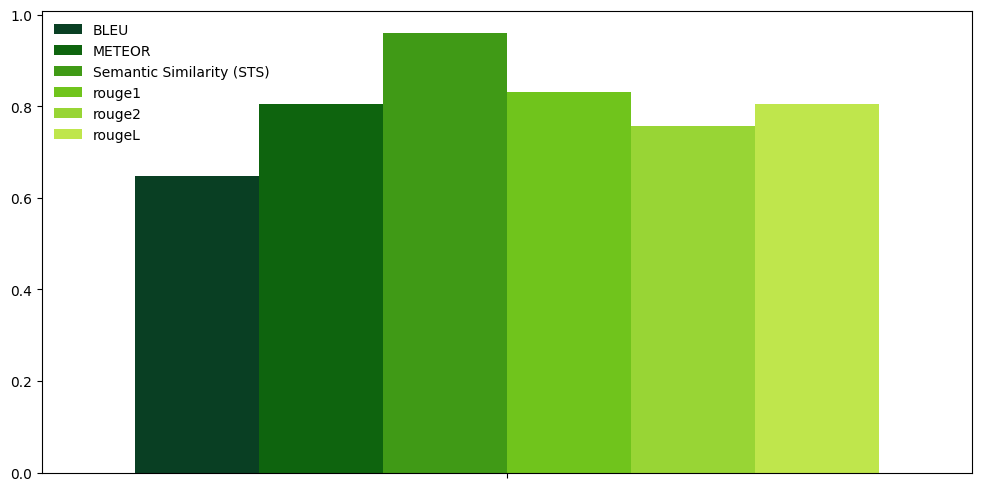

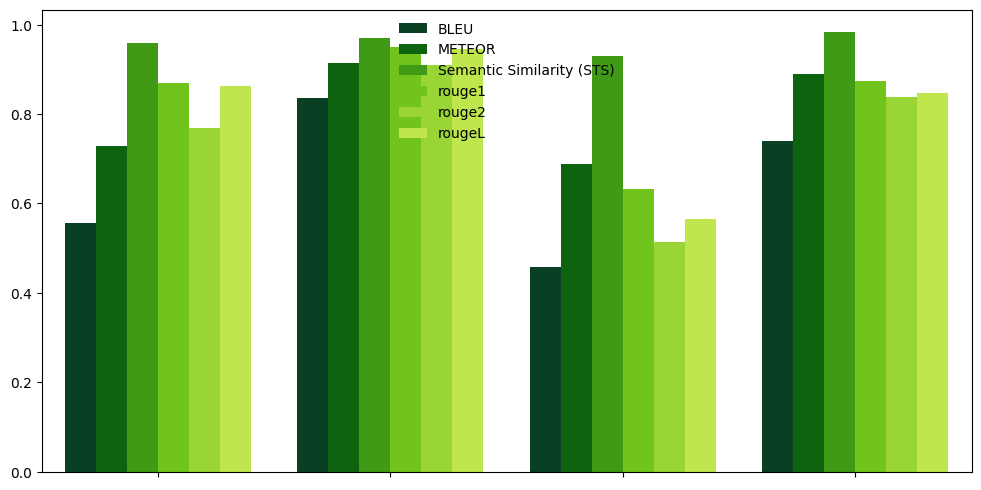

In [4]:
plot_score_comparisons(df)

In [5]:
df.to_csv("relevance_score.csv", index=False)